#QOSF screening test : task 2

Written by : Azza Fadhel, a third-year multidisciplinary engineering student.

**Task 2** :
Prepare 4 random 4-qubit quantum states of your choice.
Create and train a variational circuit that transforms input states into predefined output states. Namely
if random state 1 is provided, it returns state |0011>
if random state 2 is provided, it returns state |0101>
if random state 3 is provided, it returns state |1010>
if random state 4 is provided, it returns state |1100>
What would happen if you provided a different state?

Analyze and discuss the results.


For this work, I used the Multiclass margin classifier Tutorial from PennyLane : https://pennylane.ai/qml/demos/tutorial_multiclass_classification.html

Let's start by installing PennyLane

In [1]:
pip install pennylane

Then let’s import the prerequisite libraries:

In [2]:
import pennylane as qml
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim


we generate 4 random 4-qubits quantum states by sampling each entry from a standard normal distribution.
As it's a 4-qubits quantum state, it's a 2^4=16 dimentional state vector.

In [3]:
v0 = np.random.normal(0, 1, 16)
v1 = np.random.normal(1, 2, 16)
v2 = np.random.normal(2, 3, 16)
v3 = np.random.normal(3, 4, 16)
v0
v1
v2
v3

array([ 6.68580582,  6.44423524, -0.38128591,  1.18567406,  6.00087146,
        4.00678638,  2.04047982,  0.03738406,  3.05027538, -1.90140164,
        1.16187842,  1.32670913,  7.41466462, -1.94324675,  4.16770507,
        1.60315664])

Let's define the predefined output quantum states. These states will define the labels in the Machine Learning model.

In [4]:
#Let's define the output state
out0=np.array([0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0])
out1=np.array([0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0])
out2=np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0])
out3=np.array([0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0])

Our feature size is 9, and we will use amplitude embedding. This means that each possible amplitude (in the computational basis) will correspond to a single feature. With 4 qubits (wires), there are 16 possible states, and as such, we can encode a feature vector of size 16.

In [5]:

np.random.seed(0)
torch.manual_seed(0)

num_classes = 4
margin = 0.15
feature_size = 9
batch_size = 10
lr_adam = 0.01
train_split = 0.75
# the number of the required qubits is calculated from the number of features
num_qubits = int(np.ceil(np.log2(feature_size)))
num_layers = 6
total_iterations = 30

dev = qml.device("default.qubit", wires=num_qubits)

In [6]:
# Print the number of qubits
num_qubits 

4

###Quantum Circuit

We begin by constructing the layer that will be repeated throughout our variational quantum circuits. Each qubit has its own set of rotation gates, which are followed by entangling/CNOT gates.

In [7]:
def layer(W):
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for j in range(num_qubits - 1):
        qml.CNOT(wires=[j, j + 1])
    if num_qubits >= 2:
        # Apply additional CNOT to entangle the last with the first qubit
        qml.CNOT(wires=[num_qubits - 1, 0])

The quantum nodes that will be used are now defined. We'll use four QNodes, each representing one one-vs-all classifier, because we're implementing our multiclass classifier as multiple one-vs-all classifiers. Circuit1 determines whether a sample belongs to class 1 or not, and so on. All nodes have the same circuit architecture. For the QNodes, we use the PyTorch interface. Amplitude embedding is used to embed data in each circuit.

In [8]:
def circuit(weights, feat=None):
    qml.templates.embeddings.AmplitudeEmbedding(feat, range(num_qubits), pad=0.0, normalize=True)
    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


qnodes = []
for iq in range(num_classes):
    qnode = qml.QNode(circuit, dev, interface="torch")
    qnodes.append(qnode)

The weights parametrize the variational quantum circuit. After processing the quantum circuit's output, we apply a classical bias term. The weights of variational circuits and the classical bias term are both optimized.

In [9]:
def variational_classifier(q_circuit, params, feat):
    weights = params[0]
    bias = params[1]
    return q_circuit(weights, feat=feat) + bias

###Loss Function

Using the margin loss when implementing multiclass classifiers as a set of one-vs-all classifiers is common. The ith classifier's output, ci on input x, is interpreted into a score, si, between [-1,1]. More specifically, we have: ci(x;θ) si = ci(x;θ) The multiclass margin loss attempts to ensure that the correct class's score is higher by a certain margin than the incorrect classes' score. The mutliclass loss on a sample (x,y) where y denotes the class label can be expressed analytically as:

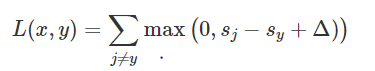

where Δ denotes the margin. The margin parameter is chosen as a hyperparameter.

In [10]:
def multiclass_svm_loss(q_circuits, all_params, feature_vecs, true_labels):
    loss = 0
    num_samples = len(true_labels)
    for i, feature_vec in enumerate(feature_vecs):
        # Compute the score given to this sample by the classifier corresponding to the
        # true label. So for a true label of 1, get the score computed by classifer 1,
        # which distinguishes between "class 1" or "not class 1".
        s_true = variational_classifier(
            q_circuits[int(true_labels[i])],
            (all_params[0][int(true_labels[i])], all_params[1][int(true_labels[i])]),
            feature_vec,
        )
        s_true = s_true.float()
        li = 0

        # Get the scores computed for this sample by the other classifiers
        for j in range(num_classes):
            if j != int(true_labels[i]):
                s_j = variational_classifier(
                    q_circuits[j], (all_params[0][j], all_params[1][j]), feature_vec
                )
                s_j = s_j.float()
                li += torch.max(torch.zeros(1).float(), s_j - s_true + margin)
        loss += li

    return loss / num_samples

###Classification Function

Next, we use the learned models to classify our samples. For a given sample, compute the score given to it by classifier i, which quantifies how likely it is that this sample belongs to class i. For each sample, return the class with the highest score.

In [11]:
def classify(q_circuits, all_params, feature_vecs, labels):
    predicted_labels = []
    for i, feature_vec in enumerate(feature_vecs):
        scores = np.zeros(num_classes)
        for c in range(num_classes):
            score = variational_classifier(
                q_circuits[c], (all_params[0][c], all_params[1][c]), feature_vec
            )
            scores[c] = float(score)
        pred_class = np.argmax(scores)
        predicted_labels.append(pred_class)
    return predicted_labels


def accuracy(labels, hard_predictions):
    loss = 0
    for l, p in zip(labels, hard_predictions):
        if torch.abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / labels.shape[0]
    return loss

###Data and Processing

Now I put the input and output states together and normalize the features so that the sum of the feature elements squared equals one (l2 norm is one).

In [12]:
# Now I will be using the v vectors that I have defined at the beginning, I constructed a vector x, which contain a multiple v0,v1,v2 and v3.
#I constructed a vector y,which contains numbers : 0 => out0, 1 => out1, 2 => out2, 3=> out3.
#Here, our data is perfect : for every vi corresponds the label of the outi.

def load_and_process_data():
    x = [v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3]
    #Let's  define the y as the labels 0,1,2,3
    y = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
    X = torch.tensor(x)
    print("First X sample, original  :", X[0])

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(y)
    return X, Y


# Create a train and test split.
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test

###Training Procedure

In the training procedure, we begin by randomly initializing the parameters we want to learn (variational circuit weights and classical bias). We set the requires grad flag to True because these are the variables we want to optimize. We use minibatch training, which computes the average loss for a batch of samples and bases the optimization step on it. With the default parameters, the total training time is about 15 minutes.

First X sample, original  : tensor([-1.7222, -0.3406, -1.4972, -1.1124, -1.1579,  0.8517, -1.7138,  1.0002,
        -2.0836,  0.9129,  0.0740,  0.3983,  0.7616, -0.7447, -0.5449, -0.0629],
       dtype=torch.float64)
First X sample, normalized: tensor([-0.3916, -0.0775, -0.3405, -0.2529, -0.2633,  0.1937, -0.3897,  0.2274,
        -0.4738,  0.2076,  0.0168,  0.0906,  0.1732, -0.1693, -0.1239, -0.0143],
       dtype=torch.float64)
Num params:  219


/usr/local/lib/python3.7/dist-packages/pennylane/templates/embeddings/amplitude.py:136: UserWarning: The pad argument will be replaced by the pad_with option in future versions of PennyLane.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Iter:     1 | Cost: 0.5216383 | Acc train: 0.2222222 | Acc test: 0.3333333 
Iter:     2 | Cost: 0.3587002 | Acc train: 0.4722222 | Acc test: 0.5833333 
Iter:     3 | Cost: 0.2492256 | Acc train: 0.6944444 | Acc test: 0.9166667 
Iter:     4 | Cost: 0.1503000 | Acc train: 0.6944444 | Acc test: 0.9166667 
Iter:     5 | Cost: 0.0889452 | Acc train: 0.6944444 | Acc test: 0.9166667 
Iter:     6 | Cost: 0.0521162 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:     7 | Cost: 0.0329585 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:     8 | Cost: 0.0435023 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:     9 | Cost: 0.0038576 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:    10 | Cost: 0.0000000 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:    11 | Cost: 0.0000000 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:    12 | Cost: 0.0000000 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:    13 | Cost: 0.0000000 | Acc train: 1.0000000 | Acc test: 1.0000000 
Iter:    14 

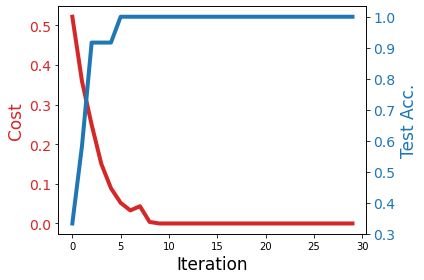

In [13]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, Y = load_and_process_data()
costs, train_acc, test_acc = training(features, Y)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

In this case, we used perfect data. Because each input data corresponds to a predetermined output data. The machine learning model overfits, returning accuracy train = 1 and accuracy test = 1. In fact, the values in the train data are similar to those in the test data.

###What would happen if you provided a different state?

In [14]:
# Here, I define an exemple of a different input state
vdiff = np.random.normal(1.5, 2.5, 16)
vdiff

array([-0.46271633, -2.51323517,  5.07960057, -3.35547531,  4.34988348,
       -0.04291483, -2.93889648, -1.29551368, -2.51596753, -0.5366902 ,
        2.30320226,  1.19017389,  1.55530314,  0.69678373,  3.23154513,
        0.61619121])

1.I put the vdiff randomly in the train and test data :



In [15]:
def load_and_process_data():

    x = [v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,vdiff,v0,vdiff,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,vdiff,v3,v0,v1,v2,v3]
    #Let's  define the y as the lavels 0,1,2,3
    y = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

    X = torch.tensor(x)
    print("First X sample, original  :", X[0])

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(y)
    return X, Y


# Create a train and test split.
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test


First X sample, original  : tensor([-1.7222, -0.3406, -1.4972, -1.1124, -1.1579,  0.8517, -1.7138,  1.0002,
        -2.0836,  0.9129,  0.0740,  0.3983,  0.7616, -0.7447, -0.5449, -0.0629],
       dtype=torch.float64)
First X sample, normalized: tensor([-0.3916, -0.0775, -0.3405, -0.2529, -0.2633,  0.1937, -0.3897,  0.2274,
        -0.4738,  0.2076,  0.0168,  0.0906,  0.1732, -0.1693, -0.1239, -0.0143],
       dtype=torch.float64)
Num params:  219


/usr/local/lib/python3.7/dist-packages/pennylane/templates/embeddings/amplitude.py:136: UserWarning: The pad argument will be replaced by the pad_with option in future versions of PennyLane.
  UserWarning,


Iter:     1 | Cost: 0.4321770 | Acc train: 0.2222222 | Acc test: 0.2500000 
Iter:     2 | Cost: 0.3666209 | Acc train: 0.7222222 | Acc test: 0.7500000 
Iter:     3 | Cost: 0.1642753 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:     4 | Cost: 0.1978498 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:     5 | Cost: 0.0836340 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:     6 | Cost: 0.0301731 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:     7 | Cost: 0.1440568 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:     8 | Cost: 0.0010539 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:     9 | Cost: 0.0000000 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:    10 | Cost: 0.0000000 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:    11 | Cost: 0.0000000 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:    12 | Cost: 0.0431667 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:    13 | Cost: 0.0000000 | Acc train: 0.9444444 | Acc test: 1.0000000 
Iter:    14 

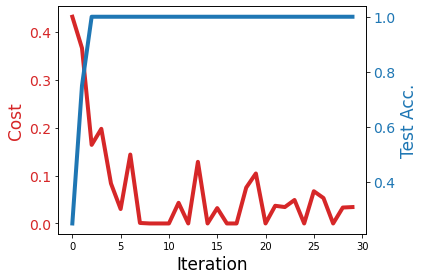

In [16]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, Y = load_and_process_data()
costs, train_acc, test_acc = training(features, Y)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

In this case, we have two vdiff values in the input state and one vdiff value in the output state. As a result, this change has an effect on the accuracy. In fact, the accuracy train decreased to 0.94 while the accuracy test remained constant at 1. Our model overfits.

2.I put the vdiff randomly only in the train data :

In [17]:
def load_and_process_data():
    x = [v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,vdiff,v0,vdiff,v2,v3,v0,v1,v2,v3,v0,v1,vdiff,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3]
    #Let's  define the y as the lavels 0,1,2,3
    y = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

    X = torch.tensor(x)
    print("First X sample, original  :", X[0])

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(y)
    return X, Y


# Create a train and test split.
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test


First X sample, original  : tensor([-1.7222, -0.3406, -1.4972, -1.1124, -1.1579,  0.8517, -1.7138,  1.0002,
        -2.0836,  0.9129,  0.0740,  0.3983,  0.7616, -0.7447, -0.5449, -0.0629],
       dtype=torch.float64)
First X sample, normalized: tensor([-0.3916, -0.0775, -0.3405, -0.2529, -0.2633,  0.1937, -0.3897,  0.2274,
        -0.4738,  0.2076,  0.0168,  0.0906,  0.1732, -0.1693, -0.1239, -0.0143],
       dtype=torch.float64)
Num params:  219


/usr/local/lib/python3.7/dist-packages/pennylane/templates/embeddings/amplitude.py:136: UserWarning: The pad argument will be replaced by the pad_with option in future versions of PennyLane.
  UserWarning,


Iter:     1 | Cost: 0.7447639 | Acc train: 0.0277778 | Acc test: 0.0000000 
Iter:     2 | Cost: 0.4623765 | Acc train: 0.0277778 | Acc test: 0.0000000 
Iter:     3 | Cost: 0.3458409 | Acc train: 0.2777778 | Acc test: 0.1666667 
Iter:     4 | Cost: 0.1854157 | Acc train: 0.4444444 | Acc test: 0.5833333 
Iter:     5 | Cost: 0.1929822 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:     6 | Cost: 0.0867039 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:     7 | Cost: 0.0579358 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:     8 | Cost: 0.1025927 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:     9 | Cost: 0.0165846 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:    10 | Cost: 0.0023857 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:    11 | Cost: 0.1306581 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:    12 | Cost: 0.0000000 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:    13 | Cost: 0.1121446 | Acc train: 0.9722222 | Acc test: 0.9166667 
Iter:    14 

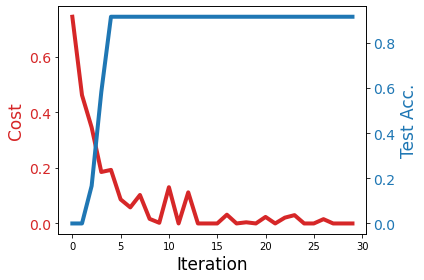

In [18]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, Y = load_and_process_data()
costs, train_acc, test_acc = training(features, Y)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

In this case, we have three vdiff values in the train data and none in the test data. As a result, this change has an effect on the accuracy. In fact, the accuracy train has dropped to 0.97, while the accuracy test has dropped to 0.91. Our model overfits.

3.I put the vdiff randomly only in the test data :

In [19]:
def load_and_process_data():
    x = [v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,vdiff,v0,vdiff,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,v2,v3,v0,v1,vdiff,v3,v0,v1,vdiff,v3,v0,v1,v2,vdiff]
     #Let's  define the y as the lavels 0,1,2,3
    y = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]


    X = torch.tensor(x)
    print("First X sample, original  :", X[0])

    # normalize each input
    normalization = torch.sqrt(torch.sum(X ** 2, dim=1))
    X_norm = X / normalization.reshape(len(X), 1)
    print("First X sample, normalized:", X_norm[0])

    Y = torch.tensor(y)
    return X, Y


# Create a train and test split.
def split_data(feature_vecs, Y):
    num_data = len(Y)
    num_train = int(train_split * num_data)
    index = np.random.permutation(range(num_data))
    feat_vecs_train = feature_vecs[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feat_vecs_test = feature_vecs[index[num_train:]]
    Y_test = Y[index[num_train:]]
    return feat_vecs_train, feat_vecs_test, Y_train, Y_test

First X sample, original  : tensor([-1.7222, -0.3406, -1.4972, -1.1124, -1.1579,  0.8517, -1.7138,  1.0002,
        -2.0836,  0.9129,  0.0740,  0.3983,  0.7616, -0.7447, -0.5449, -0.0629],
       dtype=torch.float64)
First X sample, normalized: tensor([-0.3916, -0.0775, -0.3405, -0.2529, -0.2633,  0.1937, -0.3897,  0.2274,
        -0.4738,  0.2076,  0.0168,  0.0906,  0.1732, -0.1693, -0.1239, -0.0143],
       dtype=torch.float64)
Num params:  219


/usr/local/lib/python3.7/dist-packages/pennylane/templates/embeddings/amplitude.py:136: UserWarning: The pad argument will be replaced by the pad_with option in future versions of PennyLane.
  UserWarning,


Iter:     1 | Cost: 0.5042946 | Acc train: 0.1944444 | Acc test: 0.4166667 
Iter:     2 | Cost: 0.3019893 | Acc train: 0.1666667 | Acc test: 0.3333333 
Iter:     3 | Cost: 0.4371220 | Acc train: 0.4166667 | Acc test: 0.5833333 
Iter:     4 | Cost: 0.2879733 | Acc train: 0.8888889 | Acc test: 0.9166667 
Iter:     5 | Cost: 0.1963925 | Acc train: 0.8888889 | Acc test: 0.9166667 
Iter:     6 | Cost: 0.0352133 | Acc train: 0.8888889 | Acc test: 0.9166667 
Iter:     7 | Cost: 0.1840036 | Acc train: 0.8888889 | Acc test: 0.9166667 
Iter:     8 | Cost: 0.0539832 | Acc train: 0.9166667 | Acc test: 1.0000000 
Iter:     9 | Cost: 0.0422185 | Acc train: 0.9166667 | Acc test: 1.0000000 
Iter:    10 | Cost: 0.0288075 | Acc train: 0.9166667 | Acc test: 1.0000000 
Iter:    11 | Cost: 0.1125818 | Acc train: 0.9444444 | Acc test: 0.9166667 
Iter:    12 | Cost: 0.0308008 | Acc train: 0.9444444 | Acc test: 0.9166667 
Iter:    13 | Cost: 0.0379195 | Acc train: 0.9444444 | Acc test: 0.9166667 
Iter:    14 

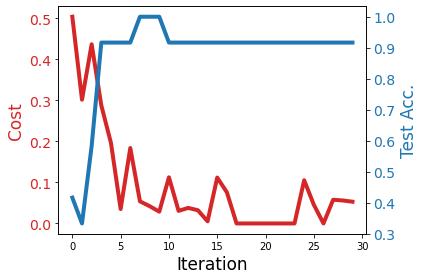

In [20]:
def training(features, Y):
    num_data = Y.shape[0]
    feat_vecs_train, feat_vecs_test, Y_train, Y_test = split_data(features, Y)
    num_train = Y_train.shape[0]
    q_circuits = qnodes

    # Initialize the parameters
    all_weights = [
        Variable(0.1 * torch.randn(num_layers, num_qubits, 3), requires_grad=True)
        for i in range(num_classes)
    ]
    all_bias = [Variable(0.1 * torch.ones(1), requires_grad=True) for i in range(num_classes)]
    optimizer = optim.Adam(all_weights + all_bias, lr=lr_adam)
    params = (all_weights, all_bias)
    print("Num params: ", 3 * num_layers * num_qubits * 3 + 3)

    costs, train_acc, test_acc = [], [], []

    # train the variational classifier
    for it in range(total_iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feat_vecs_train_batch = feat_vecs_train[batch_index]
        Y_train_batch = Y_train[batch_index]

        optimizer.zero_grad()
        curr_cost = multiclass_svm_loss(q_circuits, params, feat_vecs_train_batch, Y_train_batch)
        curr_cost.backward()
        optimizer.step()

        # Compute predictions on train and validation set
        predictions_train = classify(q_circuits, params, feat_vecs_train, Y_train)
        predictions_test = classify(q_circuits, params, feat_vecs_test, Y_test)
        acc_train = accuracy(Y_train, predictions_train)
        acc_test = accuracy(Y_test, predictions_test)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
            "".format(it + 1, curr_cost.item(), acc_train, acc_test)
        )

        costs.append(curr_cost.item())
        train_acc.append(acc_train)
        test_acc.append(acc_test)

    return costs, train_acc, test_acc


# We now run our training algorithm and plot the results. Note that
# for plotting, the matplotlib library is required

features, Y = load_and_process_data()
costs, train_acc, test_acc = training(features, Y)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
iters = np.arange(0, total_iterations, 1)
colors = ["tab:red", "tab:blue"]
ax1.set_xlabel("Iteration", fontsize=17)
ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
ax1.plot(iters, costs, color=colors[0], linewidth=4)
ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

ax2 = ax1.twinx()
ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
ax2.plot(iters, test_acc, color=colors[1], linewidth=4)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

plt.grid(False)
plt.tight_layout()
plt.show()

We have no vdiff values in the train data and three vdiff values in the test data. As a result, this change has an effect on the accuracy. In fact, the accuracy train decreased to 0.91 while the accuracy test remained at 1. Our model is overfits.

###Analyze and discuss the results.

As shown in the three examples, when we include a different element in the data, the accuracy decreases automatically because the model used two different x data with the same label. As a result, the model's output is inaccurate, and it overfits.

Actually, I used very small data in this notebook because I wanted to see the results of a 4 random 4-qubits state. However, to avoid overfitting and achieve better results, I recommend running a generative model that can generate a large amount of data. To distinguish between real and fake data, the generative model can be followed by a discriminative model. As a result, we will have a more accurate classification model.

###Some future works

I have a few suggestions for how we can improve our model. Due to a lack of time, I was unable to test them:


1-A generative network model is used.

2-Apply multiple variational quantum circuit models.

3-Use multiple optimization algorithms and explain the impact of each one.

4-Make use of various PennyLane Plugins.

5-Try to reduce noise after applying the model to a real quantum device.

Finally, I'd like to express my gratitude for providing me with the opportunity to think about and solve the problem.